In [1]:
# development code
%load_ext autoreload
%autoreload 2

### Retrieve metric metadata from SQLite db and metric data from .npz files

Now we are going to make some plots of the output of the previous notebook.

### Software Setup (repeat each session)

In [2]:
# import common python packages
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys, glob
import pandas as pd
import numpy as np

##### Detect and Set Your SciServer Username
__Note:__ Your usename will be used to store MAF output, so please make sure it is correct.

In [3]:
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
    ' If it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311. If it is incorrect, please mannually reset it.


##### Import the $\texttt{rubin_sim}$ modules needed.

In [4]:
# import rubin_sim python modules
import rubin_sim.maf.db as db
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.plots as plots
import rubin_sim.maf.metricBundles as metricBundles

# import convenience functions for MAF analysis on SciServer
from opsimUtils import *

# print version
import rubin_sim
rubin_sim.__version__

'0.7.1.dev169+g40b47c7'

### 1. Read result SQLite db and read in metric data
Each time you run MAF on an opsim simulation, MAF produces two types of files:
1. `*.db`: A SQLite database storing metadata and summary statistics for each metric run on the opsims.
2. `*.npz`: A file storing metric values (e.g., those used to generated plots and histograms) per metric and per opsim. The name of this file is also stored in the above `*.db` files.

If you followed the [Introduction](./Introduction.ipynb) notebook, metadata for metrics run on each opsim will be stored in separate files (using the convention 'runName_result.db', otherwise all in one 'resultDb_sqlite.db' by default). You can easily retrieve the metadata from those files using the provided conveience functions.

**Note:** You can either provide the path to the directory where all the resulting SQLite databases are stored or hard code the paths to each individual result database.

To read results stored in files, we need the paths to two directories:
1. `resultDbPath`: The path to the directory where the `runName_result.db` metadata databases are stored.
2. `metricDataPath`: The path to the directory where the actual metric data (`*.npz` files) are stored.

In [5]:
# user provided paths
resultDbPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput'.format(your_username)
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/'.format(your_username)

In [6]:
# get a dictionary of resultDb from given directory
resultDbs = getResultsDbs(resultDbPath)

# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())

In [7]:
# retrieve metricBundles for each opsim run and store them in a dictionary
bundleDicts = {}

for runName in resultDbs:
    bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

#### BundleDict Keys:
If you have gone through all the previous notebooks ([Introduction.ipynb](./00_Introduction.ipynb)) and [Multiple_Opsims.ipynb](./01_Multiple_Opsims.ipynb), you should be familiar with the term 'bundleDict' and 'metricBundle'. A metricBundle is a combination of metric (e.g., CoaddM5), slicer (e.g., healpixSlicer) and sql constraint (e.g., filter = 'g') and a bundleDict is a dictionary of multiple metricBundles. Each item in the `bundleDicts` shown in the cell above is one bundleDict. While reconstructing the bundleDict, we give each metricBundle a tuple key in the format of ('metricId', 'metricName'). metricId is unique while metricName is not, that is you can run same metric using differerent sql constraints. To make sure that we are comparing apples to apples, the `plotHist()` function and `plotSky()` function, which will be introducted below, require the tuple metricKey instead of just the metric name. 

In [8]:
# we see the available metric keys
list(bundleDicts[runNames[0]].keys())

[(1, 'CoaddM5'), (2, 'CoaddM5'), (3, 'Max airmass')]

The 2nd and the 3rd have the same metric name, but we can see the difference between the two by retrieving the full metadata using `get_metricMetadata()`. Note that the keys of `bundleDicts`, `resultDbs` are opSim run names. 

In [9]:
print('{}: '.format(runNames[0])) # show the opsim run name where the metric metadata comes from
get_metricMetadata(resultDbs[runNames[0]], metricName='CoaddM5')

baseline_retrofoot_v2.0_10yrs: 


,metricId,metricName,slicerName,sqlConstraint,metricMetadata,metricDataFile
0,1,CoaddM5,HealpixSlicer,"filter = ""u"" and note not like ""DD%""",u and note not like DD%,baseline_retrofoot_v2_0_10yrs_CoaddM5_u_and_no...
1,2,CoaddM5,HealpixSlicer,"filter = ""y"" and note not like ""DD%""",y and note not like DD%,baseline_retrofoot_v2_0_10yrs_CoaddM5_y_and_no...


### 2. Compare opSims using summary statistics

You can retrieve all summary statistics stored in the metadata using function `getSummary()`. This function will return a dictionary, each item is an array of summary statistics for the required metric. You can pass `pandas = True` to this function to get a pandas dataframe instead.

In [10]:
summary = getSummary(resultDbs, 'CoaddM5', 'Rms', pandas=True)
summary

,metricId,summaryName,metricName,slicerName,metricMetadata,summaryMetric,summaryValue,runName
0,1,Rms CoaddM5 u and note not like DD% HealpixSlicer,CoaddM5,HealpixSlicer,u and note not like DD%,Rms,0.374417,baseline_retrofoot_v2.0_10yrs
1,2,Rms CoaddM5 y and note not like DD% HealpixSlicer,CoaddM5,HealpixSlicer,y and note not like DD%,Rms,0.496873,baseline_retrofoot_v2.0_10yrs
2,1,Rms CoaddM5 u and note not like DD% HealpixSlicer,CoaddM5,HealpixSlicer,u and note not like DD%,Rms,0.412016,baseline_v2.0_10yrs
3,2,Rms CoaddM5 y and note not like DD% HealpixSlicer,CoaddM5,HealpixSlicer,y and note not like DD%,Rms,0.529671,baseline_v2.0_10yrs
4,1,Rms CoaddM5 u and note not like DD% HealpixSlicer,CoaddM5,HealpixSlicer,u and note not like DD%,Rms,0.418931,bluer_indx0_v2.0_10yrs
5,2,Rms CoaddM5 y and note not like DD% HealpixSlicer,CoaddM5,HealpixSlicer,y and note not like DD%,Rms,0.537337,bluer_indx0_v2.0_10yrs
6,1,Rms CoaddM5 u and note not like DD% HealpixSlicer,CoaddM5,HealpixSlicer,u and note not like DD%,Rms,0.436358,bluer_indx1_v2.0_10yrs
7,2,Rms CoaddM5 y and note not like DD% HealpixSlicer,CoaddM5,HealpixSlicer,y and note not like DD%,Rms,0.527858,bluer_indx1_v2.0_10yrs
8,1,Rms CoaddM5 u and note not like DD% HealpixSlicer,CoaddM5,HealpixSlicer,u and note not like DD%,Rms,0.410044,virgo_cluster_v2.0_10yrs
9,2,Rms CoaddM5 y and note not like DD% HealpixSlicer,CoaddM5,HealpixSlicer,y and note not like DD%,Rms,0.531799,virgo_cluster_v2.0_10yrs


Next, we use a simple function to generate a bar plot for comparing opsim using the summary statistics.

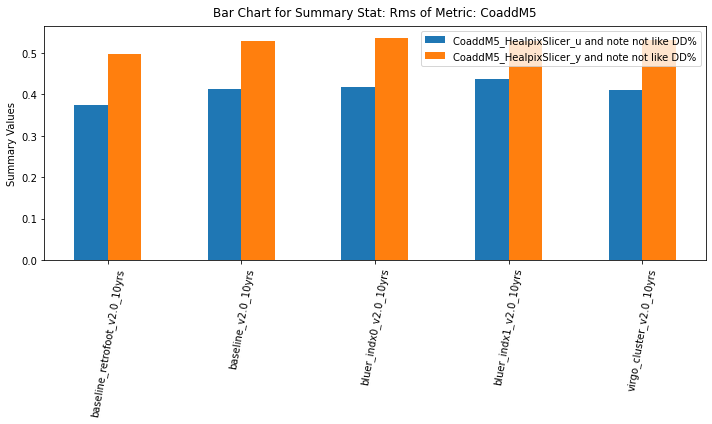

In [11]:
plotSummaryBar(resultDbs, 'CoaddM5', 'Rms', slicerName = 'HealpixSlicer')

Two convenience functions, `get_metricNames` and `get_summaryStatName`, are provided to check what metrics are available and and what summary statistics were run on a given metric.

In [12]:
get_metricNames(resultDbs[runNames[0]])

['CoaddM5', 'Max airmass']

In [13]:
getSummaryStatNames(resultDbs[runNames[0]], 'CoaddM5')

[{'metricId': 1,
  'StatNames': ['Max CoaddM5 u and note not like DD% HealpixSlicer',
   'Median CoaddM5 u and note not like DD% HealpixSlicer',
   'Min CoaddM5 u and note not like DD% HealpixSlicer',
   'Rms CoaddM5 u and note not like DD% HealpixSlicer']},
 {'metricId': 2,
  'StatNames': ['Max CoaddM5 y and note not like DD% HealpixSlicer',
   'Median CoaddM5 y and note not like DD% HealpixSlicer',
   'Min CoaddM5 y and note not like DD% HealpixSlicer',
   'Rms CoaddM5 y and note not like DD% HealpixSlicer']}]

### 3. Generate plots (hist/sky) using metric data
The following plotting functions, `plotHist()` and `plotSky()`, are simply an extension to the code provided in the [Introduction](./00_Introduction.ipynb) notebook. These functions are provided for quick visualization, you can easily make better looking plots by using the metric values loaded into metricbundles directly. For how to access the metric values, please look at the [Introduction](./00_Introduction.ipynb) notebook.  

Note that both functions require you to provide a **tuple** metric key

/home/idies/workspace/Storage/ywx649999311/persistent/LSST_Cadence/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 234 bins, returning 200
  warnings.warn(
/home/idies/workspace/Storage/ywx649999311/persistent/LSST_Cadence/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 344 bins, returning 200
  warnings.warn(


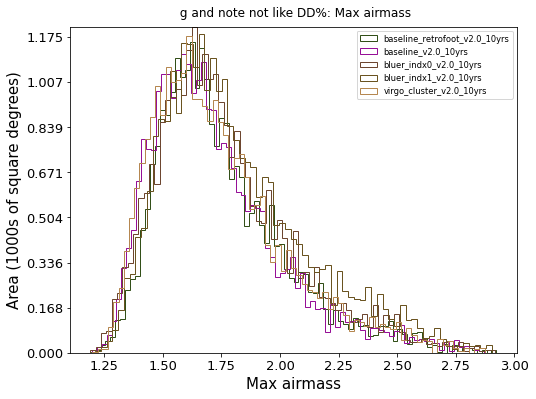

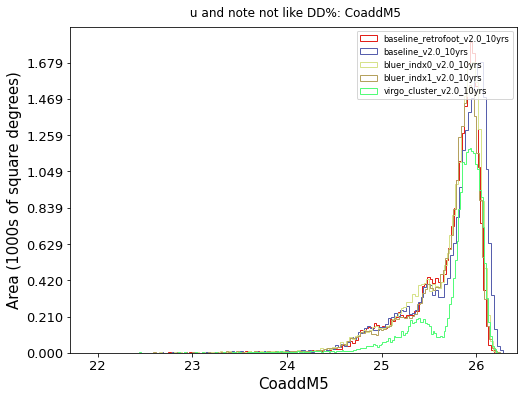

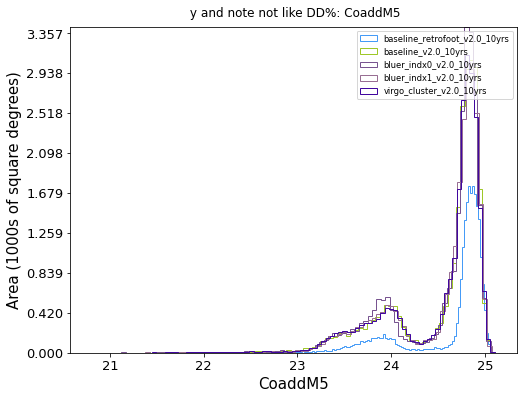

In [14]:
# plot hist for both metric of all opsims in one figure
plotHist(bundleDicts, (3, 'Max airmass'))
plotHist(bundleDicts, (1, 'CoaddM5'))
plotHist(bundleDicts, (2, 'CoaddM5'))

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


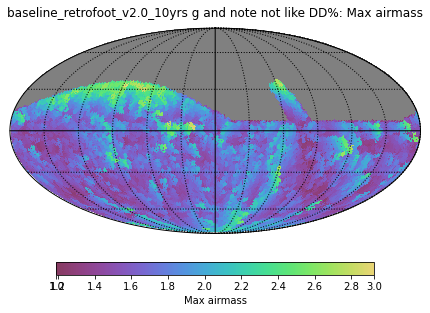

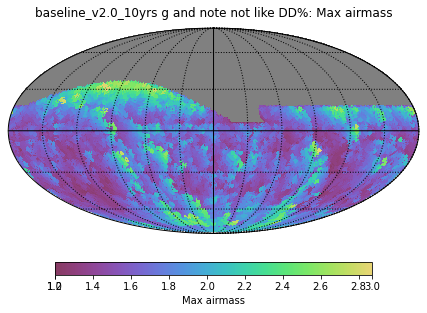

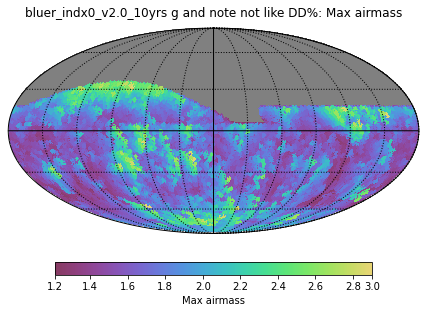

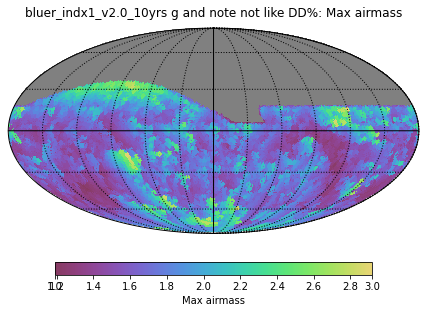

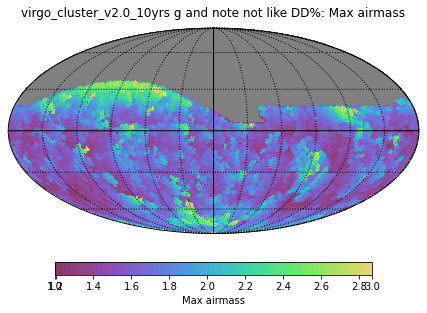

In [15]:
# Make sky plots
plotSky(bundleDicts, (3, 'Max airmass'))